# Modelling

In [1]:
from pyspark.sql import SparkSession, functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("modelling")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

22/08/29 07:22:40 WARN Utils: Your hostname, AryansLaptop resolves to a loopback address: 127.0.1.1; using 172.18.205.204 instead (on interface eth0)
22/08/29 07:22:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/29 07:22:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

sdf = spark.read.parquet('../data/curated/mergedf.paraquet')
tdf = spark.read.parquet('../data/curated/testdf.paraquet')
tdf.limit(5)

PULocationID,count,temperature(f),dew_point_temp(f),relative_humidity,wind_speed,month,day,pickup_hour
151,4,41.0,37.0,85.54,4.0,2,1,4
238,13,39.9,36.0,85.81,6.0,2,1,6
52,7,39.0,36.0,88.87,5.0,2,1,8
87,17,39.0,36.0,88.87,5.0,2,1,8
237,218,39.9,36.0,85.81,4.0,2,1,14


In [3]:
# VectorAssembler creates new vectors from existing columns
from pyspark.ml.feature import VectorAssembler

features = 'features'
input_cols = ["PULocationID","month","day","pickup_hour","temperature(f)","wind_speed"]

assembler = VectorAssembler(
    # which column to combine
    inputCols=input_cols, 
    # How should the combined columns be named
    outputCol=features
)

model_sdf = assembler.transform(sdf.dropna('any'))
# Display the features and targets for our model
model_sdf.select('features').head(5), model_sdf.select('count').head(5)

([Row(features=DenseVector([138.0, 3.0, 1.0, 10.0, 30.9, 8.0])),
  Row(features=DenseVector([158.0, 3.0, 1.0, 17.0, 35.1, 6.0])),
  Row(features=DenseVector([142.0, 3.0, 1.0, 20.0, 35.1, 7.0])),
  Row(features=DenseVector([209.0, 3.0, 1.0, 23.0, 35.1, 9.0])),
  Row(features=DenseVector([35.0, 3.0, 2.0, 1.0, 35.1, 11.0]))],
 [Row(count=278), Row(count=66), Row(count=146), Row(count=25), Row(count=2)])

In [4]:
from pyspark.ml.regression import DecisionTreeRegressor

model = DecisionTreeRegressor(
    featuresCol='features', 
    labelCol='count',
    maxDepth=12,
    maxBins=263
).fit(model_sdf)

In [5]:
# preprocess for predictions
predict_test = tdf.select(*input_cols)

assembler = VectorAssembler(
    inputCols=input_cols, 
    outputCol=features
)

predict_sdf = assembler.transform(predict_test).select(features)

predict_sdf.show(1, vertical=True)

-RECORD 0------------------------
 features | [151.0,2.0,1.0,4.... 
only showing top 1 row



In [6]:
predictions = model.transform(predict_sdf)
predictions.limit(5)

features,prediction
"[151.0,2.0,1.0,4....",5.674157303370786
"[238.0,2.0,1.0,6....",49.288184438040346
"[52.0,2.0,1.0,8.0...",12.124054462934946
"[87.0,2.0,1.0,8.0...",31.859716682712143
"[237.0,2.0,1.0,14...",310.3216619981326


In [7]:
import numpy as np
ytest =  np.array(tdf.select("count").collect())
ypred = np.array(predictions.select("prediction").collect())
ypred

array([[ 5.6741573 ],
       [49.28818444],
       [12.12405446],
       ...,
       [ 1.50366461],
       [ 1.48739496],
       [ 1.92091541]])

In [8]:
import numpy as np
from sklearn.metrics import mean_absolute_error as mae
print(np.round(mae(ytest,ypred), 2))
print(ytest.min(),ytest.max(),ytest.mean(),ytest.std())

16.57
1 829 40.238589527386964 77.18504247654607


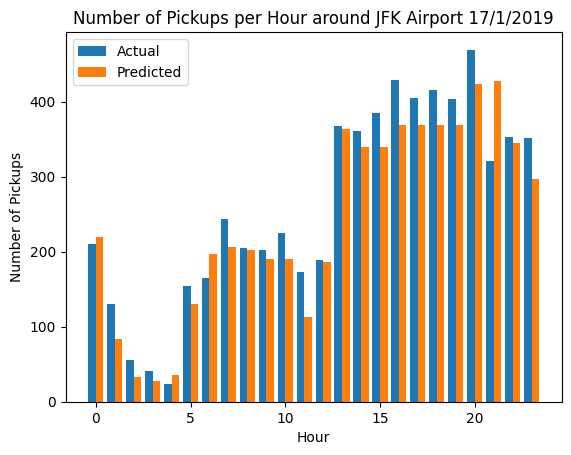

In [10]:
# Plots the actual and predicted values for decision trees

from pyspark.sql import functions as F
import matplotlib.pyplot as plt

LOC = 132
MONTH = 1
DAY = 17

# gets the values in the testdataframe that match with the randomly chosen values for the constants 
actual = tdf.filter(
    (F.col("PULocationid") == LOC)
    & (F.col("month") == MONTH)
    & (F.col("day") == DAY)
).orderBy("pickup_hour")
actual

# gets predictions for those location-month-day hour 
predict_test = actual.select(*input_cols)
assembler = VectorAssembler(
    inputCols=input_cols, 
    outputCol=features
)
predict_sdf = assembler.transform(predict_test).select(features)
predictions = model.transform(predict_sdf)
predictions = predictions.select("prediction")
predictions # one column array holding all the predictions for the given location-month-day rows

df = actual.toPandas()
dfp = predictions.toPandas()
X = df["pickup_hour"]  
X_axis = np.arange(len(X)) 
plt.bar(X_axis - 0.2, df["count"], 0.4, label = 'Actual')
plt.bar(X_axis + 0.2, dfp["prediction"], 0.4, label = 'Predicted')
plt.legend()
plt.xlabel('Hour')
plt.ylabel('Number of Pickups')
plt.title('Number of Pickups per Hour around JFK Airport 17/1/2019')
plt.savefig("../plots/tree.png")


In [11]:
# finds the mean average error for differnt num tree params

from pyspark.ml.regression import RandomForestRegressor

x=[]
y=[]
# goes through num tree param 1 by 1 building a new model over each
for i in range(1,11):
    model = RandomForestRegressor(
        featuresCol='features',
        labelCol='count',
        maxDepth=12,
        maxBins=263,
        numTrees=i
    ).fit(model_sdf)

    predict_test = tdf.select(*input_cols)
    assembler = VectorAssembler(
        inputCols=input_cols, 
        outputCol=features
    )
    predict_sdf = assembler.transform(predict_test).select(features)
    predictions = model.transform(predict_sdf)

    ytest =  np.array(tdf.select("count").collect())
    ypred = np.array(predictions.select("prediction").collect())

    y.append(np.round(mae(ytest,ypred), 2))
    x.append(i)
print(x)
print(y)


22/08/29 07:24:34 WARN DAGScheduler: Broadcasting large task binary with size 1000.7 KiB
22/08/29 07:24:39 WARN DAGScheduler: Broadcasting large task binary with size 1406.2 KiB


22/08/29 07:24:45 WARN DAGScheduler: Broadcasting large task binary with size 1104.9 KiB
22/08/29 07:24:46 WARN DAGScheduler: Broadcasting large task binary with size 1933.8 KiB


22/08/29 07:24:52 WARN DAGScheduler: Broadcasting large task binary with size 1342.9 KiB
22/08/29 07:24:53 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/29 07:24:59 WARN DAGScheduler: Broadcasting large task binary with size 1604.9 KiB


22/08/29 07:25:00 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/29 07:25:07 WARN DAGScheduler: Broadcasting large task binary with size 1049.5 KiB
22/08/29 07:25:08 WARN DAGScheduler: Broadcasting large task binary with size 1897.7 KiB


22/08/29 07:25:09 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/29 07:25:18 WARN DAGScheduler: Broadcasting large task binary with size 1199.5 KiB
22/08/29 07:25:19 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/29 07:25:20 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/29 07:25:22 WARN DAGScheduler: Broadcasting large task binary with size 1048.3 KiB


22/08/29 07:25:29 WARN DAGScheduler: Broadcasting large task binary with size 1320.2 KiB


22/08/29 07:25:30 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/29 07:25:31 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/29 07:25:34 WARN DAGScheduler: Broadcasting large task binary with size 1181.8 KiB


22/08/29 07:25:41 WARN DAGScheduler: Broadcasting large task binary with size 1423.9 KiB


22/08/29 07:25:42 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/29 07:25:44 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/29 07:25:46 WARN DAGScheduler: Broadcasting large task binary with size 1279.8 KiB


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[16.68, 39.84, 35.54, 37.25, 35.68, 36.86, 36.46, 36.38, 35.66, 33.92]


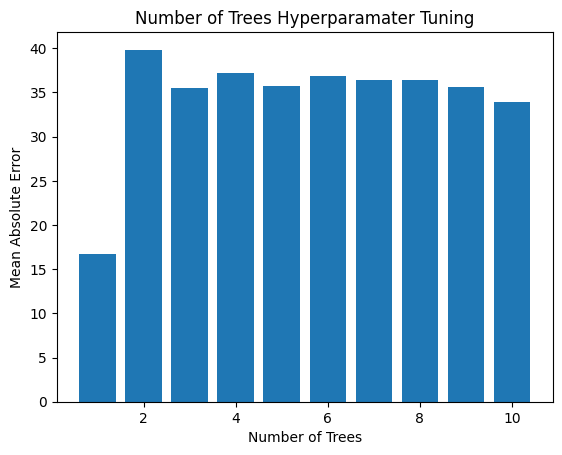

In [12]:
# Plots the mean absolute error values for each every random forest variation

plt.bar(x,y)
plt.xlabel('Number of Trees')
plt.ylabel('Mean Absolute Error')
plt.title('Number of Trees Hyperparamater Tuning')
plt.savefig("../plots/param.png")